In [1]:
!git clone https://github.com/duyvuleo/VNTC.git

Cloning into 'VNTC'...
remote: Enumerating objects: 39, done.
remote: Total 39 (delta 0), reused 0 (delta 0), pack-reused 39
Unpacking objects: 100% (39/39), done.
Checking out files: 100% (15/15), done.


In [2]:
!unrar x -Y "/content/VNTC/Data/10Topics/Ver1.1/Test_Full.rar" "/content/VNTC/Data/10Topics/Ver1.1/"
!unrar x -Y "/content/VNTC/Data/10Topics/Ver1.1/Train_Full.rar" "/content/VNTC/Data/10Topics/Ver1.1/"

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Extracting  /content/VNTC/Data/10Topics/Ver1.1/Train_Full/Kinh doanh/KD_ VNE_ (376).txt      83%  OK 
Extracting  /content/VNTC/Data/10Topics/Ver1.1/Train_Full/Kinh doanh/KD_ VNE_ (55).txt      83%  OK 
Extracting  /content/VNTC/Data/10Topics/Ver1.1/Train_Full/Kinh doanh/KD_ VNE_ (75).txt      83%  OK 
Extracting  /content/VNTC/Data/10Topics/Ver1.1/Train_Full/Kinh doanh/KD_ VNE_ (77).txt      83%  OK 
Extracting  /content/VNTC/Data/10Topics/Ver1.1/Train_Full/Kinh doanh/KD_ VNE_ (85).txt      83%  OK 
Extracting  /content/VNTC/Data/10Topics/Ver1.1/Train_Full/Kinh doanh/KD_ VNE_ (89).txt      83%  OK 
Extracting  /content/VNTC/Data/10Topics/Ver1.1/Train_Full/Kinh doanh/KD_ VNE_ (90).txt      83%  OK 
Extracting  /content/VNTC/Data/10Topics/Ver1.1/Train_Full/Kinh doanh/KD_ VNE_ (91).txt      83%  OK 
Extracting  /content/VNTC/Data/10Topics/Ver1.1/Train_Full/Kinh

In [3]:
!pip3 install fairseq
!pip3 install fastbpe
!pip3 install vncorenlp
!pip3 install transformers
!pip3 install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.0 MB 4.2 MB/s 
     |████████████████████████████████| 116 kB 52.6 MB/s 
     |████████████████████████████████| 235 kB 60.1 MB/s 
     |████████████████████████████████| 123 kB 12.6 MB/s 
     |████████████████████████████████| 112 kB 54.0 MB/s 
     |████████████████████████████████| 596 kB 52.7 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=68ddb6d107bd27b7681af56df168cc50b441e756aa11018392246161a3e69547
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
Successfully built antlr4-python3-runtime
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/col

In [4]:
import os
import re
import torch
from transformers import AutoModel, AutoTokenizer
import numpy as np
import pickle
from vncorenlp import VnCoreNLP
import underthesea
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
def save_dump(file_path, data, labels):
    file = open(file_path, 'wb')
    # dump information to that file
    pickle.dump((data, labels), file)
    # close the file
    file.close()
    pass


def load_data(path_file):
    file = open(path_file, 'rb')
    # dump information to that file
    (pixels, labels) = pickle.load(file)
    # close the file
    file.close()
    print(pixels.shape)
    print(labels.shape)
    return pixels, labels


def load_pho_bert():
    pho_bert = AutoModel.from_pretrained("vinai/phobert-base")
    tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
    return pho_bert, tokenizer


def standardize_data(row):
    # Xóa dấu chấm, phẩy, hỏi ở cuối câu
    row = re.sub(r"[\,\?]+$-()!*=._", "", row)
    row = row.replace(",", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("*", " ")\
        .replace("=", " ").replace("(", " ")\
        .replace(")", " ").replace("_", " ").replace(".", " ")
    row = row.strip().lower()
    return row


def get_data_line_decode_token(v_token, max_len, max_line):
    data_line = []
    data_token = []
    cnt_line = 0
    cnt_code = 0
    for code in v_token:
        if cnt_line == max_line:
            print("Full 300 word")
            return data_line
        
        if cnt_code == max_len:
            data_line.append(data_token)
            cnt_line += 1
            cnt_code = 0
            data_token = []

        data_token.append(code)
        cnt_code += 1
    if len(data_line) < max_line:
        data_line.append(data_token)
    if len(data_line) < max_line:
        for i in range(0, max_line - len(data_line)):
            data_line.append([])
    return data_line


def get_pho_bear_feature(v_pho_bert, data_token, max_len_word):
    v_tokenized = []
    v_tokenized.append(data_token)
    padded = np.array([i + [1] * (max_len_word - len(i)) for i in v_tokenized])

    # Đánh dấu các từ thêm vào = 0 để không tính vào quá trình lấy features
    attention_mask = np.where(padded == 1, 0, 1)

    # Chuyển thành tensor
    padded = torch.tensor(padded).to(torch.long)
    attention_mask = torch.tensor(attention_mask)

    # Lấy features dầu ra từ BERT
    with torch.no_grad():
        last_hidden_states = v_pho_bert(input_ids=padded, attention_mask=attention_mask)

    # print(last_hidden_states)
    # print(last_hidden_states[0][:, 0, :].numpy().shape)
    v_features = last_hidden_states[0][:, 0, :].numpy().T
    # print(v_features.shape)

    return v_features


def get_text_feature(sentence, v_pho_bert, v_tokenizer, max_line, max_len_word):
    data_feature = []
    word_segmented_text = underthesea.word_tokenize(sentence)
    
    line = " ".join(word_segmented_text)
    line = underthesea.word_tokenize(line, format="text")
    v_token = v_tokenizer.encode(line)

    data_line_token = get_data_line_decode_token(v_token, max_len_word, max_line)
    for data_token in data_line_token:
        feature_token = get_pho_bear_feature(v_pho_bert, data_token, max_len_word)
        data_feature.append(feature_token)
    
    # print(np.array(data_feature).shape)

    data_feature = np.array(data_feature)
    
    print(data_feature.shape)
    return data_feature


def load_data_post_directory(DIRECTORY, CATEGORIES, cnt_max_category, max_line, max_len_word, output_shape):
    print("[INFO] loading post...")
    data = []
    labels = []
    pho_bert, v_token = load_pho_bert()
    for category in CATEGORIES:
        path = os.path.join(DIRECTORY, category)
        print(path)
        cnt_category = 0
        for post in os.listdir(path):
            if cnt_category == cnt_max_category:
                break
            post_path = os.path.join(path, post)
            print(post_path)
            f = open(post_path, "r", encoding='utf-16')
            text_post = f.read()
            text_post = standardize_data(text_post)

            v_feat = get_text_feature(text_post, pho_bert, v_token, max_line, max_len_word)

            if v_feat.shape != output_shape:
                print("Error shape data : ", v_feat.shape)
                print(post_path)
                return

            data.append(v_feat)
            labels.append(category)
            cnt_category += 1

    dataset = np.array(data)
    labels = np.array(labels)
    return dataset, labels

# Analytics data
def view_analytics_data_post(people, performance):
    plt.rcdefaults()
    fig, ax = plt.subplots()

    # Data
    y_pos = np.arange(len(people))
    error = np.random.rand(len(people))

    ax.barh(y_pos, performance, xerr=error, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(people)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Performance')
    ax.set_title('Analytics')
    plt.show()


def analytics_data_post_directory(DIRECTORY, CATEGORIES, cnt_max_category):
    print("[INFO] loading post...")

    analytics_word = []
    for category in CATEGORIES:
        path = os.path.join(DIRECTORY, category)
        print(category)
        cnt_category = 0

        lst_cnt_word = []
        for post in os.listdir(path):
            if cnt_category == cnt_max_category:
                break

            post_path = os.path.join(path, post)
            print(post_path)
            f = open(post_path, "r", encoding='utf-16')
            text_post = f.read()
            text_post = standardize_data(text_post)
            word_segmented_text = underthesea.word_tokenize(text_post)
            lst_cnt_word.append(len(word_segmented_text))

        avg_category = np.average(lst_cnt_word)
        analytics_word.append(avg_category)
    
    view_analytics_data_post(CATEGORIES, analytics_word)
    return analytics_word

In [7]:
# Dataset
DIRECTORY_test = "/content/VNTC/Data/10Topics/Ver1.1/Test_Full"
DIRECTORY_train = "/content/VNTC/Data/10Topics/Ver1.1/Train_Full"
CATEGORIES = ['Chinh tri Xa hoi', 'Doi song', 'Khoa hoc', 
              'Kinh doanh', 'Phap luat', 'Suc khoe',
              'The gioi', 'The thao', 'Van hoa', 'Vi tinh']

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
/content/VNTC/Data/10Topics/Ver1.1/Train_Full/Van hoa/VH_VNE_ (245).txt
/content/VNTC/Data/10Topics/Ver1.1/Train_Full/Van hoa/VH_VNE_ (2047).txt
/content/VNTC/Data/10Topics/Ver1.1/Train_Full/Van hoa/VH_NLD_ (3743).txt
/content/VNTC/Data/10Topics/Ver1.1/Train_Full/Van hoa/VH_VNE_ (3100).txt
/content/VNTC/Data/10Topics/Ver1.1/Train_Full/Van hoa/VH_VNE_ (351).txt
/content/VNTC/Data/10Topics/Ver1.1/Train_Full/Van hoa/VH_VNE_ (68).txt
/content/VNTC/Data/10Topics/Ver1.1/Train_Full/Van hoa/VH_VNE_ (670).txt
/content/VNTC/Data/10Topics/Ver1.1/Train_Full/Van hoa/VH_TN_ (3650).txt
/content/VNTC/Data/10Topics/Ver1.1/Train_Full/Van hoa/VH_VNE_ (2879).txt
/content/VNTC/Data/10Topics/Ver1.1/Train_Full/Van hoa/VH_VNE_ (2097).txt
/content/VNTC/Data/10Topics/Ver1.1/Train_Full/Van hoa/VH_VNE_ (2900).txt
/content/VNTC/Data/10Topics/Ver1.1/Train_Full/Van hoa/VH_VNE_ (2871).txt
/content/VNTC/Data/10Topics/Ver1.1/Train_Full/Van hoa/VH_VNE_ (668).txt
/

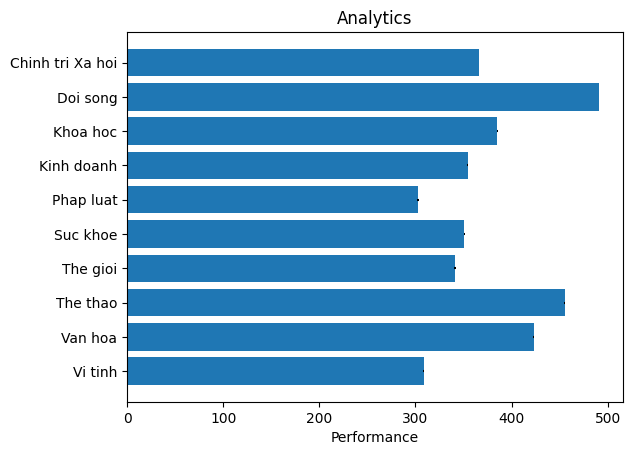

[366.06131442805133,
 491.3526432415321,
 385.3192307692308,
 354.41653605015676,
 302.5524819027921,
 350.681146572104,
 340.848171152519,
 455.1132502831257,
 422.8581168831169,
 308.6606207174526]

In [8]:
cnt_post = 2000
analytics_data_post_directory(DIRECTORY_train, CATEGORIES, cnt_post)

In [ ]:
line = 3 
word_in_line = 100
cnt_post = 1000
output_shape = (3, 768, 1)

data_train, labels_train = load_data_post_directory(DIRECTORY_train, ['The gioi', 'The thao', 'Van hoa', 'Vi tinh'], 
                                                    cnt_post, line, word_in_line, output_shape)
data_train.shape, labels_train.shape

In [11]:
save_path = '/content/drive/MyDrive/GHTK/RnD/Data_Post'

save_dump(os.path.join(save_path, 'data_train_2.data'), data_train, labels_train)

In [ ]:
# test
pho_bert, v_token = load_pho_bert()
f = open('/content/VNTC/Data/10Topics/Ver1.1/Train_Full/Phap luat/PL_NLD_ (4639).txt', "r", encoding='utf-16')
text_post = f.read()
text_post = standardize_data(text_post)
v_feat = get_text_feature(text_post, pho_bert, v_token, 3, 100)
v_feat